# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

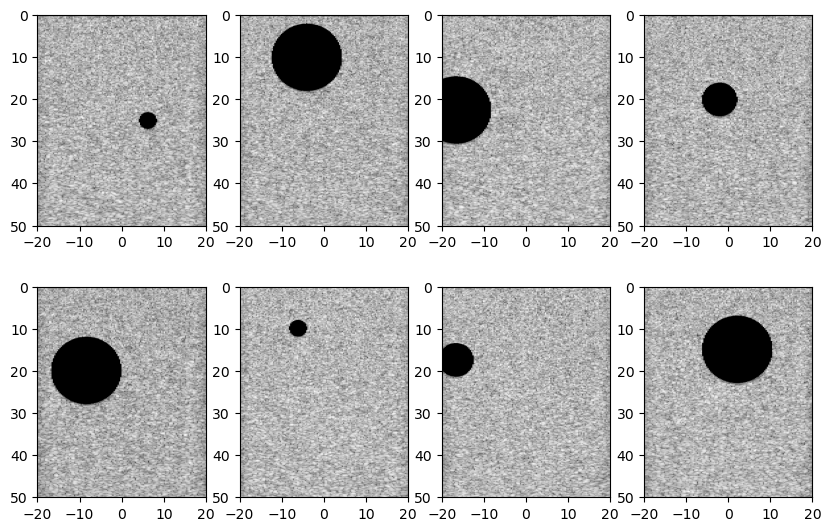

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from diffusion_utils import CustomDataset

def show_images(datset, num_samples=8, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(10,10))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[1].squeeze(), cmap='gray', extent=[-20,20,50,0])

input_folder = r'C:\Users\u_imagenes\Documents\smerino\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\target_enh'
data = CustomDataset(input_folder, output_folder, transform=True)

show_images(data)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

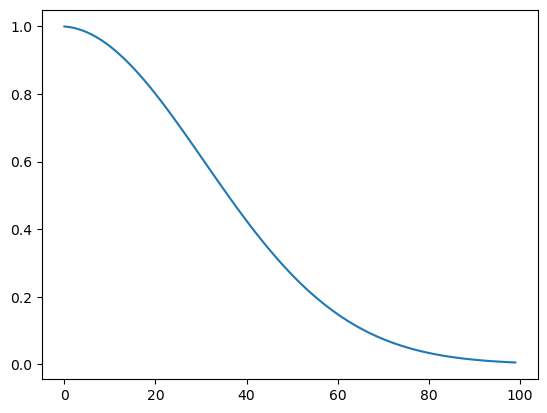

In [3]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 100
betas = linear_beta_schedule(timesteps=T, start=0.0001*5, end=0.02*5)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

plt.plot(alphas_cumprod)
plt.show()

Let's test it on our dataset ...

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

BATCH_SIZE = 8

def load_transformed_dataset():
    return CustomDataset(input_folder, output_folder, transform=True)

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image), cmap='gray', extent=[-20,20,50,0])

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

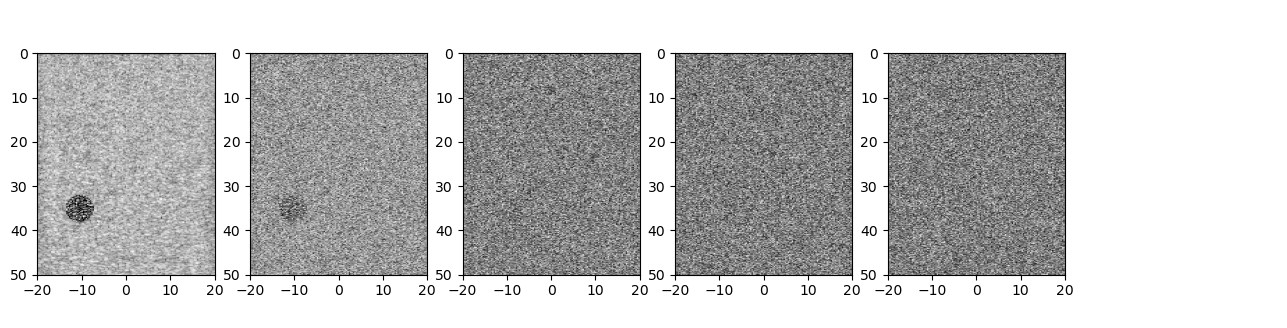

In [5]:
# Simulate forward diffusion
image = next(iter(dataloader))[1]

plt.figure(figsize=(16,4))
plt.axis('off')
num_images = 5
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [7]:
from model2 import UNETv7
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

# Model and normalization
save_dir = r'.\weights_v7'
training_epochs = 200
model = UNETv7(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  34278401


UNETv7(
  (ups): ModuleList(
    (0): DoubleConv(
      (conv1): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (time_mlp): EmbedTimeLayer(
        (model): Sequential(
          (0): SinusoidalPositionEmbeddings()
          (1): Linear(in_features=32, out_features=512, bias=True)
          (2): ReLU()
          (3): Linear(in_features=512, out_features=512, bias=True)
          (4): ReLU()
        )
      )
      (shortcut): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): DoubleConv(
      (conv1): Sequential(
        (0


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [8]:
def get_loss(model, x_0, t):
    device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [27]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
    HEIGHT = 800
    WIDTH = 128
    img = torch.randn((1, 1, WIDTH, HEIGHT), device=device)
    plt.figure(figsize=(16,4))
    plt.axis('off')
    num_images = 5
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [60]:
@torch.no_grad()
def sample_timestep_cond(input, t, model):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    x = input[:,2,:,:]
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(input, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image_cond(x, model):
    # Sample noise
    device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
    x = x.to(device)
    HEIGHT = 800
    WIDTH = 128
    img = torch.randn((1, 1, HEIGHT, WIDTH), device=device)
    plt.figure(figsize=(16,4))
    plt.axis('off')
    num_images = 5
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        # print(img.shape)
        # print(x.shape)
        input = torch.cat((x, img), 1)
        img = sample_timestep_cond(input, t, model)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()
    return img.detach().cpu()

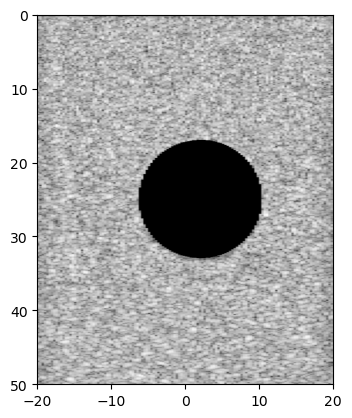

In [61]:
dataloader = DataLoader(data, batch_size=1, shuffle=True, drop_last=True)
x_sample, y_sample = next(iter(dataloader))
show_tensor_image(y_sample)

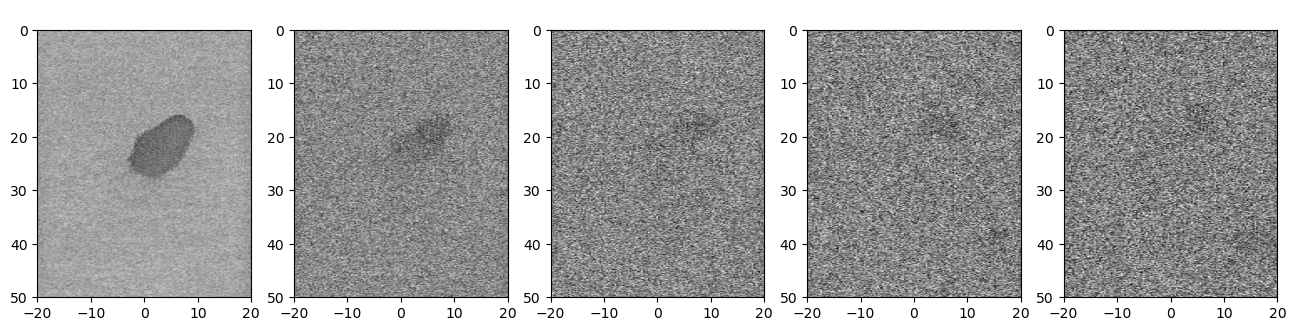

In [62]:
y_generated = sample_plot_image_cond(x_sample,model)

In [63]:
from model2 import UNETv6

# Model and normalization
save_dir = r'.\weights_v6'
training_epochs = 200
model_6 = UNETv6(in_channels=3, out_channels=1).to(device)
model_6.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
model_6.eval()

UNETv6(
  (ups): ModuleList(
    (0): DoubleConv(
      (conv1): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (time_mlp): EmbedTimeLayer(
        (model): Sequential(
          (0): SinusoidalPositionEmbeddings()
          (1): Linear(in_features=32, out_features=512, bias=True)
          (2): ReLU()
          (3): Linear(in_features=512, out_features=512, bias=True)
          (4): ReLU()
        )
      )
      (shortcut): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): DoubleConv(
      (conv1): Sequential(
        (0

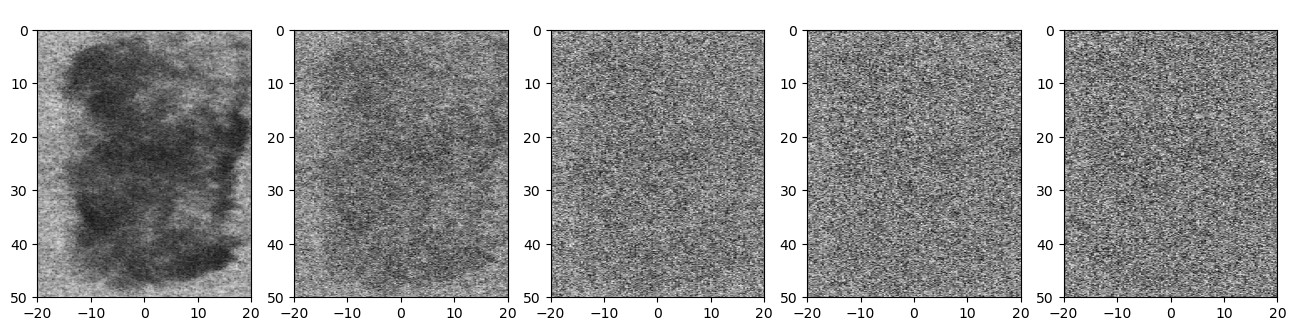

In [65]:
y_generated = sample_plot_image_cond(x_sample,model_6)